Code ref.
+ https://www.kaggle.com/tanetboss/beginner-binary-classification-for-nice-movie
+ https://www.kaggle.com/fabiendaniel/film-recommendation-engine

In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # used for plot interactive graph.


from numpy import median
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

from pylab import rcParams

%matplotlib inline

In [2]:
#credit to 
def load_tmdb_movies(path):
    data = pd.read_csv(path)
    data['release_date'] = pd.to_datetime(data['release_date']).apply(lambda x : x.date())
    json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
    for col in json_columns:
        data[col] = data[col].apply(json.loads)
    return data

def load_tmdb_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

In [3]:
# Columns that existed in the IMDB version of the dataset and are gone.
LOST_COLUMNS = [
    'actor_1_facebook_likes',
    'actor_2_facebook_likes',
    'actor_3_facebook_likes',
    'aspect_ratio',
    'cast_total_facebook_likes',
    'color',
    'content_rating',
    'director_facebook_likes',
    'facenumber_in_poster',
    'movie_facebook_likes',
    'movie_imdb_link',
    'num_critic_for_reviews',
    'num_user_for_reviews'
                ]

# Columns in TMDb that had direct equivalents in the IMDB version. 
# These columns can be used with old kernels just by changing the names
TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES = {
    'budget': 'budget',
    'genres': 'genres',
    'revenue': 'gross',
    'title': 'movie_title',
    'runtime': 'duration',
    'original_language': 'language',  # it's possible that spoken_languages would be a better match
    'keywords': 'plot_keywords',
    'vote_count': 'num_voted_users',
                                         }

IMDB_COLUMNS_TO_REMAP = {'imdb_score': 'vote_average'}

def safe_access(container, index_values):
    # return a missing value rather than an error upon indexing/key failure
    result = container
    try:
        for idx in index_values:
            result = result[idx]
        return result
    except IndexError or KeyError:
        return pd.np.nan


def get_director(crew_data):
    directors = [x['name'] for x in crew_data if x['job'] == 'Director']
    return safe_access(directors, [0])


def pipe_flatten_names(keywords):
    return '|'.join([x['name'] for x in keywords])

def convert_to_original_format(movies, credits):
    # Converts TMDb data to make it as compatible as possible with kernels built on the original version of the data.
    tmdb_movies = movies.copy()
    tmdb_movies.rename(columns=TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES, inplace=True)
    tmdb_movies['title_year'] = pd.to_datetime(tmdb_movies['release_date']).apply(lambda x: x.year)
    # I'm assuming that the first production country is equivalent, but have not been able to validate this
    tmdb_movies['country'] = tmdb_movies['production_countries'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['language'] = tmdb_movies['spoken_languages'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['director_name'] = credits['crew'].apply(get_director)
    tmdb_movies['actor_1_name'] = credits['cast'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['actor_2_name'] = credits['cast'].apply(lambda x: safe_access(x, [1, 'name']))
    tmdb_movies['actor_3_name'] = credits['cast'].apply(lambda x: safe_access(x, [2, 'name']))
    tmdb_movies['companies_1'] = tmdb_movies['production_companies'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['companies_2'] = tmdb_movies['production_companies'].apply(lambda x: safe_access(x, [1, 'name']))
    tmdb_movies['companies_3'] = tmdb_movies['production_companies'].apply(lambda x: safe_access(x, [2, 'name']))
    tmdb_movies['genres'] = tmdb_movies['genres'].apply(pipe_flatten_names)
    tmdb_movies['plot_keywords'] = tmdb_movies['plot_keywords'].apply(pipe_flatten_names)
    return tmdb_movies

In [4]:
movies_data = load_tmdb_movies('tmdb_5000_movies.csv')
credits_data = load_tmdb_credits('tmdb_5000_credits.csv')
data = convert_to_original_format(movies_data, credits_data)

In [5]:
data.head(5)

,budget,genres,homepage,id,plot_keywords,language,original_title,overview,popularity,production_companies,...,num_voted_users,title_year,country,director_name,actor_1_name,actor_2_name,actor_3_name,companies_1,companies_2,companies_3
0,237000000,Action|Adventure|Fantasy|Science Fiction,http://www.avatarmovie.com/,19995,culture clash|future|space war|space colony|so...,English,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...",...,11800,2009.0,United States of America,James Cameron,Sam Worthington,Zoe Saldana,Sigourney Weaver,Ingenious Film Partners,Twentieth Century Fox Film Corporation,Dune Entertainment
1,300000000,Adventure|Fantasy|Action,http://disney.go.com/disneypictures/pirates/,285,ocean|drug abuse|exotic island|east india trad...,English,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...",...,4500,2007.0,United States of America,Gore Verbinski,Johnny Depp,Orlando Bloom,Keira Knightley,Walt Disney Pictures,Jerry Bruckheimer Films,Second Mate Productions
2,245000000,Action|Adventure|Crime,http://www.sonypictures.com/movies/spectre/,206647,spy|based on novel|secret agent|sequel|mi6|bri...,Français,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...",...,4466,2015.0,United Kingdom,Sam Mendes,Daniel Craig,Christoph Waltz,Léa Seydoux,Columbia Pictures,Danjaq,B24
3,250000000,Action|Crime|Drama|Thriller,http://www.thedarkknightrises.com/,49026,dc comics|crime fighter|terrorist|secret ident...,English,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{'name': 'Legendary Pictures', 'id': 923}, {'...",...,9106,2012.0,United States of America,Christopher Nolan,Christian Bale,Michael Caine,Gary Oldman,Legendary Pictures,Warner Bros.,DC Entertainment
4,260000000,Action|Adventure|Science Fiction,http://movies.disney.com/john-carter,49529,based on novel|mars|medallion|space travel|pri...,English,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{'name': 'Walt Disney Pictures', 'id': 2}]",...,2124,2012.0,United States of America,Andrew Stanton,Taylor Kitsch,Lynn Collins,Samantha Morton,Walt Disney Pictures,NaN,NaN


In [6]:
#missing data
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
homepage,3091,0.643556
companies_3,2479,0.516136
companies_2,1417,0.295024
tagline,844,0.175724
companies_1,351,0.073079


In [7]:
data.columns

Index(['budget', 'genres', 'homepage', 'id', 'plot_keywords', 'language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'gross', 'duration',
       'spoken_languages', 'status', 'tagline', 'movie_title', 'vote_average',
       'num_voted_users', 'title_year', 'country', 'director_name',
       'actor_1_name', 'actor_2_name', 'actor_3_name', 'companies_1',
       'companies_2', 'companies_3'],
      dtype='object')

In [10]:
#drop feature will not know before release
data.drop(['num_voted_users','popularity','vote_average'],axis=1,inplace=True)

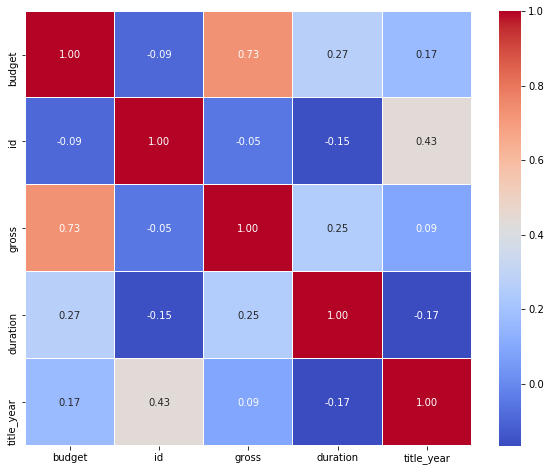

In [11]:
# Correlation matrix between numerical values
plt.figure(figsize = (10,8))
g = sns.heatmap(data[list(data)].corr(),annot=True, fmt = ".2f", cmap = "coolwarm",linewidths= 0.01)

### From heatmap
We can find out that 'budget' and 'duration' has an impact to 'gross' 

## Scatter the above feature to 'gross'

### budget and gross

<Figure size 720x720 with 0 Axes>

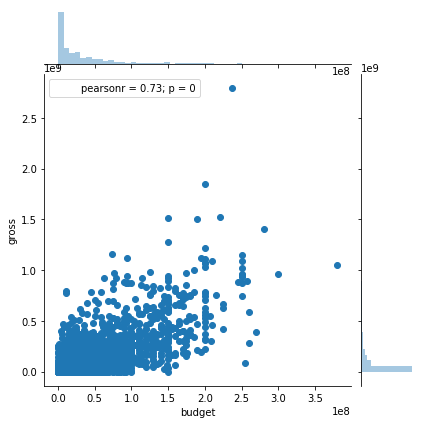

In [13]:
plt.figure(figsize = (10,10))
sns.jointplot(x="budget", y="gross", data=data);

### duration and gross

<Figure size 720x720 with 0 Axes>

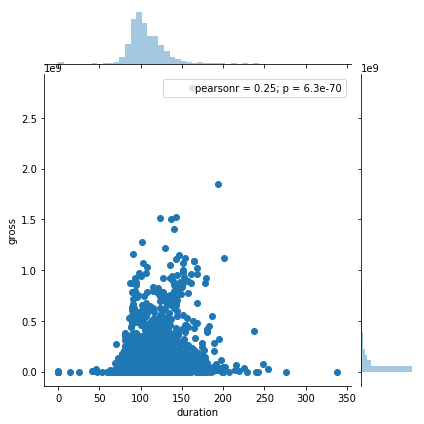

In [14]:
plt.figure(figsize = (10,10))
sns.jointplot(x="duration", y="gross", data=data);

In [21]:
#skip the row-data whose budget is 0 and duration is 0
print('Numbers of original data: %s'%(len(data)))
data = data[data['budget']!=0]
data = data[data['duration']!=0]
data = data[data['gross']!=0]
print('Numbers of data after skipping: %s'%(len(data)))

Numbers of original data: 3764
Numbers of data after skipping: 3229


### Gross Class Table

Class         | Interval (Million)  |
--------------|:-------------------:|
1             |<1                   |
2             |1 - 10               |
3             |10 - 20              |
4             |20 - 40              |
5             |40 - 65              |
6             |65 - 100             |
7             |100 - 150            |
8             |150 - 200            |
9             |200 <                |



In [44]:
data['gross_group'] = 1
data['gross_group'][(data['gross']>=1e+6)&(data['gross']<10e+6)] = 2
data['gross_group'][(data['gross']>=10e+6)&(data['gross']<20e+6)] = 3
data['gross_group'][(data['gross']>=20e+6)&(data['gross']<40e+6)] = 4
data['gross_group'][(data['gross']>=40e+6)&(data['gross']<65e+6)] = 5
data['gross_group'][(data['gross']>=65e+6)&(data['gross']<100e+6)] = 6
data['gross_group'][(data['gross']>=100e+6)&(data['gross']<150e+6)] = 7
data['gross_group'][(data['gross']>=150e+6)&(data['gross']<200e+6)] = 8
data['gross_group'][(data['gross']>=200e+6)] = 9

In [49]:
target_y = data['gross_group'].values

In [71]:
gross_frequency[:,1]

array([152, 404, 353, 459, 377, 360, 336, 227, 561], dtype=int64)

<BarContainer object of 9 artists>

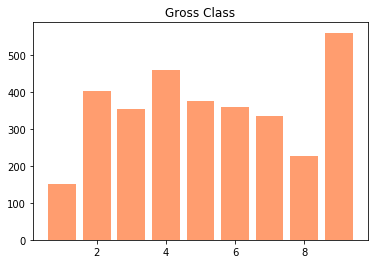

In [79]:
#plot the hist of gross
ii = np.nonzero(np.bincount(target_y))[0]
gross_frequency = np.vstack((ii,np.bincount(target_y)[ii])).T
plt.title('Gross Class')
plt.bar(gross_frequency[:,0],gross_frequency[:,1],facecolor='#ff9d6f')

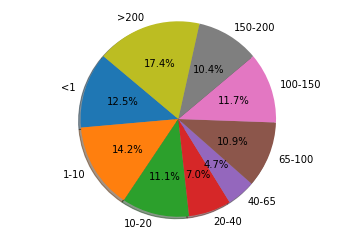

In [82]:
# Data to plot
labels =["<1","1-10","10-20","20-40","40-65","65-100","100-150","150-200",">200"]
sizes = data['gross_group'].value_counts(sort = False)
colors = ["Darkgrey","whitesmoke"]
explode = (0.1,0)  # explode 1st slice
 
# Plot
plt.pie(sizes, labels=labels,
        autopct='%1.1f%%', shadow=True, startangle=140,)
plt.axis('equal')
plt.show()

### Duration

In [84]:
# Create new feature of duration

data['ShortMovie'] = data['duration'].map(lambda s: 1 if s < 90 else 0)
data['NotTooLongMovie'] = data['duration'].map(lambda s: 1 if 90 <= s < 120 else 0)
data['LongMovie'] = data['duration'].map(lambda s: 1 if   s >= 120  else 0)

### Genres

In [85]:
# Obtaining a list of genres
genre_details = list(map(str,(data['genres'])))
genre = []
for i in genre_details:
    split_genre = list(map(str, i.split('|')))
    for j in split_genre:
        if j not in genre:
            genre.append(j)
# printing list of seperated genres.
print(genre)

['Action', 'Adventure', 'Fantasy', 'Science Fiction', 'Crime', 'Drama', 'Thriller', 'Animation', 'Family', 'Western', 'Comedy', 'Romance', 'Horror', 'Mystery', 'History', 'War', 'Music', 'Documentary', 'Foreign', '']


In [86]:
for word in genre:
    data[word] = data['genres'].map(lambda s: 1 if word in str(s) else 0)
data.loc[:,'Action': 'Foreign'].head(20)

,Action,Adventure,Fantasy,Science Fiction,Crime,Drama,Thriller,Animation,Family,Western,Comedy,Romance,Horror,Mystery,History,War,Music,Documentary,Foreign
0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
7,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


There are many keyword, How many keywords should I use.

**Credit : https://www.kaggle.com/fabiendaniel/film-recommendation-engine**


In [87]:
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):        
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue        
        for s in [s for s in liste_keywords if s in liste]: 
            if pd.notnull(s): keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

In [88]:
set_keywords = set()
for liste_keywords in data['plot_keywords'].str.split('|').values:
    if isinstance(liste_keywords, float): continue  # only happen if liste_keywords = NaN
    set_keywords = set_keywords.union(liste_keywords)
#_________________________
# remove null chain entry
set_keywords.remove('')

In [89]:
keyword_occurences, dum = count_word(data, 'plot_keywords', set_keywords)

In [90]:
## Funtion to find top 10 in list

def TopTen(theList):
    TopTen = list()

    for i in range(0, 10):
        TopTen.append(theList[i][0])
    
    return TopTen

In [92]:
from wordcloud import WordCloud

def makeCloud(Dict,name,color):
    words = dict()

    for s in Dict:
        words[s[0]] = s[1]

        wordcloud = WordCloud(
                      width=1500,
                      height=500, 
                      background_color=color, 
                      max_words=10,
                      max_font_size=500, 
                      normalize_plurals=False)
        wordcloud.generate_from_frequencies(words)


    fig = plt.figure(figsize=(12, 8))
    plt.title(name)
    plt.imshow(wordcloud)
    plt.axis('off')

    plt.show()

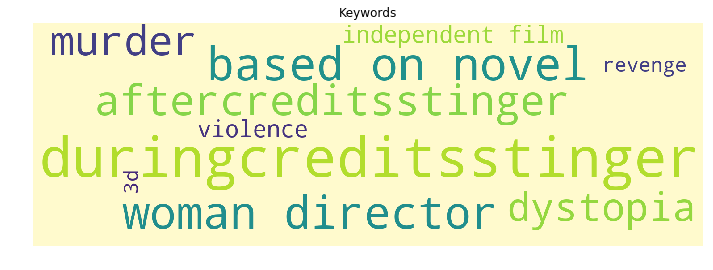

In [93]:
makeCloud(keyword_occurences[0:10],"Keywords","lemonchiffon")

In [94]:
for word in TopTen(keyword_occurences):
    data[word] = data['plot_keywords'].map(lambda s: 1 if word in str(s) else 0)

    
data.drop('plot_keywords',axis=1,inplace=True)
data.loc[:,'woman director':].head()

,woman director,aftercreditsstinger,murder,dystopia,independent film,violence,3d,revenge
0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0


### Director

In [95]:
data['director_name'].fillna('unknown',inplace=True)

In [96]:
def to_frequency_table(data):
    frequencytable = {}
    for key in data:
        if key in frequencytable:
            frequencytable[key] += 1
        else:
            frequencytable[key] = 1
    return frequencytable

In [97]:
director_dic = to_frequency_table(data['director_name'])
director_list = list(director_dic.items())
director_list.sort(key=lambda tup: tup[1],reverse=True)

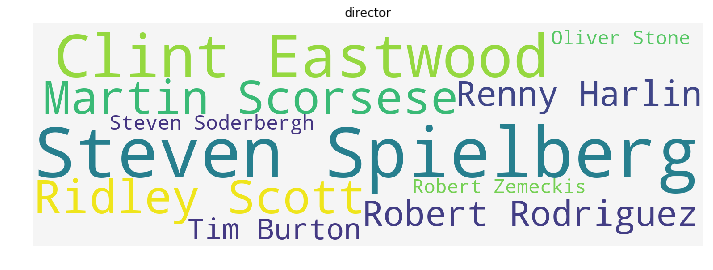

In [98]:
makeCloud(director_list[0:10],"director","whitesmoke")

In [99]:
for word in TopTen(director_list):
    data[word] = data['director_name'].map(lambda s: 1 if word in str(s) else 0)

data.loc[:,'Steven Spielberg': ].head()

,Steven Spielberg,Clint Eastwood,Ridley Scott,Martin Scorsese,Robert Rodriguez,Renny Harlin,Tim Burton,Steven Soderbergh,Robert Zemeckis,Oliver Stone
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


### Actor

In [100]:
data['actor_1_name'].fillna('unknown',inplace=True)

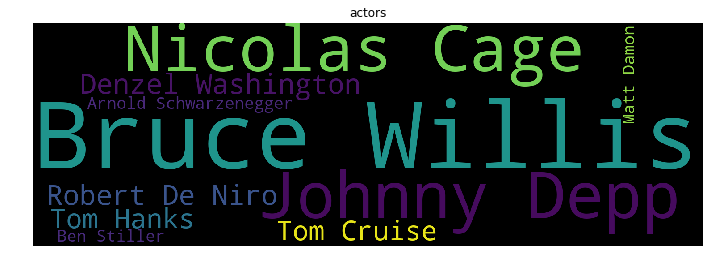

In [101]:
actor_dic = to_frequency_table(data['actor_1_name'])
actor_list = list(actor_dic.items())
actor_list.sort(key=lambda tup: tup[1],reverse=True)
makeCloud(actor_list[0:10],"actors","black")

In [102]:
for word in TopTen(actor_list):
    data[word] = data['actor_1_name'].map(lambda s: 1 if word in str(s) else 0)

data.loc[:,'Bruce Willis':].head()

,Bruce Willis,Johnny Depp,Nicolas Cage,Denzel Washington,Robert De Niro,Tom Hanks,Tom Cruise,Arnold Schwarzenegger,Matt Damon,Ben Stiller
0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


### Company

In [103]:
data['companies_1'].fillna('unknown',inplace=True)

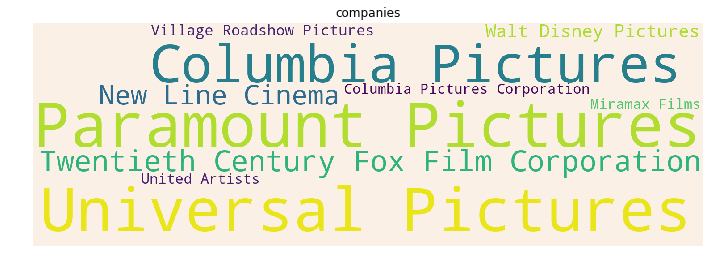

In [104]:
comp_dic = to_frequency_table(data['companies_1'])
comp_list = list(comp_dic.items())
comp_list.sort(key=lambda tup: tup[1],reverse=True)
makeCloud(comp_list[0:10],"companies","linen")

In [111]:
for word in TopTen(comp_list):
    data[word] = data['companies_1'].map(lambda s: 1 if word == s else 0)

data.loc[:,'Paramount Pictures':].head()

,Paramount Pictures,Universal Pictures,Columbia Pictures,Twentieth Century Fox Film Corporation,New Line Cinema,Walt Disney Pictures,Village Roadshow Pictures,Miramax Films,United Artists,Columbia Pictures Corporation
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0


In [113]:
data.drop(['id','homepage','original_title','overview','gross','title_year',
           'spoken_languages','production_companies','production_countries',
           'release_date','status','tagline','movie_title','language',
           'director_name','actor_1_name','actor_2_name','actor_3_name',
          'companies_1','companies_2','companies_3','country','genres','duration'],
          axis=1, inplace=True)

In [117]:
data.drop([],
          axis=1, inplace=True)

#### Check missing data

In [114]:
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
Columbia Pictures Corporation,0,0.0
Western,0,0.0
aftercreditsstinger,0,0.0
woman director,0,0.0
based on novel,0,0.0


In [118]:
data['is_train'] = np.random.uniform(0, 1, len(data)) <= .75

# View the top 5 rows
data.head()

,budget,gross_group,ShortMovie,NotTooLongMovie,LongMovie,Action,Adventure,Fantasy,Science Fiction,Crime,...,Universal Pictures,Columbia Pictures,Twentieth Century Fox Film Corporation,New Line Cinema,Walt Disney Pictures,Village Roadshow Pictures,Miramax Films,United Artists,Columbia Pictures Corporation,is_train
0,237000000,9,0,0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,True
1,300000000,9,0,0,1,1,1,1,0,0,...,0,0,0,0,1,0,0,0,0,True
2,245000000,9,0,0,1,1,1,0,0,1,...,0,1,0,0,0,0,0,0,0,False
3,250000000,9,0,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,True
4,260000000,9,0,0,1,1,1,0,1,0,...,0,0,0,0,1,0,0,0,0,True


### split training and testing data with ratio of 3:1

In [119]:
# Create two new dataframes, one with the training rows, one with the test rows
train, test = data[data['is_train']==True].copy(), data[data['is_train']==False].copy()

train["gross_group"] = train["gross_group"].astype(int)

Y_train = train["gross_group"]
X_train = train.drop(labels = ["gross_group"],axis = 1)
Y_test = test["gross_group"]
X_test = test.drop(labels = ["gross_group"],axis = 1)

## Decision Tree

In [120]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [121]:
from sklearn.model_selection import  cross_val_score

c_dec = cross_val_score(clf, X_train, Y_train, cv=10)
c_dec.mean()

0.1272852865644206

In [122]:
test_result = np.asarray(Y_test)

In [153]:
result = clf.predict(X_test)[:]

Dec_result = pd.DataFrame(result,columns=["Predict"])
Dec_result['testAnswer'] = pd.DataFrame(test_result)

Dec_result['Correct'] = np.where((Dec_result['Predict'] == Dec_result['testAnswer'])
                     , 1, 0)
Dec_result.head()

,Predict,testAnswer,Correct
0,9,9,1
1,9,9,1
2,9,9,1
3,9,9,1
4,9,9,1


In [154]:
Dec_result['Correct'].mean()

0.25161290322580643

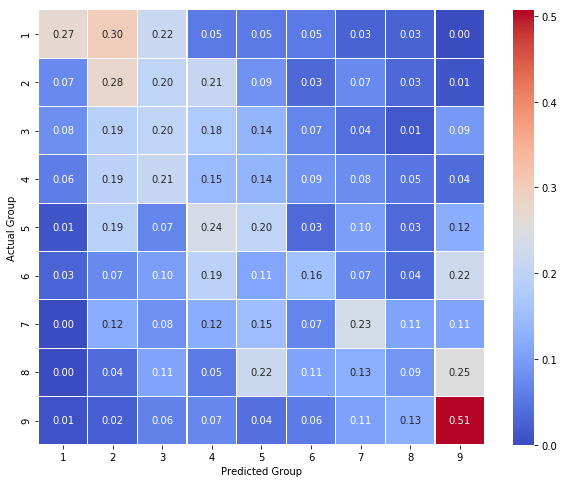

In [171]:
# Create confusion matrix
CROSSTAB = pd.crosstab(Dec_result['testAnswer'], Dec_result['Predict'], rownames=['Actual Group'], colnames=['Predicted Group'])
for i in range(9):
    CROSSTAB.loc[i+1]/=sum(CROSSTAB.loc[i+1])
plt.figure(figsize = (10,8))
g = sns.heatmap(CROSSTAB,annot=True, fmt = ".2f", cmap = "coolwarm",linewidths= 0.01)

## K-Nearest Neighbors

In [125]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors= 60 )
knn.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=60, p=2,
           weights='uniform')

In [126]:
c_knn = cross_val_score(knn, X_train, Y_train, cv=10)
c_knn.mean()

0.14064805675047415

In [147]:
result = knn.predict(X_test)[:]

knn_result = pd.DataFrame(result,columns=["Predict"])
knn_result['testAnswer'] = pd.DataFrame(test_result)

knn_result['Correct'] = np.where((knn_result['Predict'] == knn_result['testAnswer'])
                     , 1, 0)
knn_result.head()

,Predict,testAnswer,Correct
0,9,9,1
1,9,9,1
2,9,9,1
3,9,9,1
4,9,9,1


In [148]:
knn_result['Correct'].mean()

0.2787096774193548

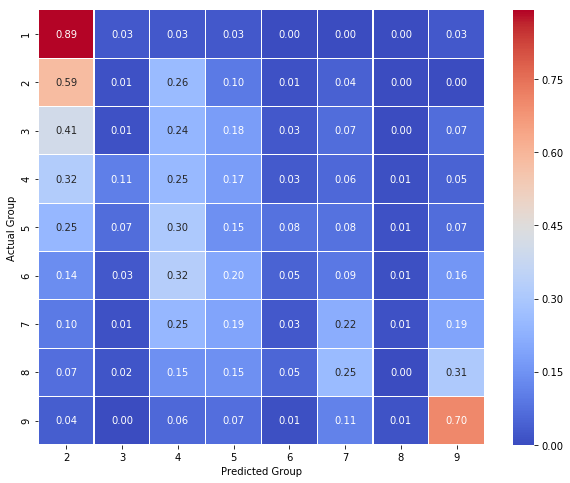

In [170]:
# Create confusion matrix
CROSSTAB = pd.crosstab(knn_result['testAnswer'], knn_result['Predict'], rownames=['Actual Group'], colnames=['Predicted Group'])
for i in range(9):
    CROSSTAB.loc[i+1]/=sum(CROSSTAB.loc[i+1])
plt.figure(figsize = (10,8))
g = sns.heatmap(CROSSTAB,annot=True, fmt = ".2f", cmap = "coolwarm",linewidths= 0.01)

## Random Forest

In [135]:
from sklearn.ensemble import RandomForestClassifier

Rfclf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
Rfclf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [136]:
c_rf =  cross_val_score(Rfclf, X_train, Y_train, cv=10)
c_rf.mean()

0.22760704749452093

In [143]:
result = Rfclf.predict(X_test)[:]

Rf_result = pd.DataFrame(result,columns=["Predict"])
Rf_result['testAnswer'] = pd.DataFrame(test_result)

Rf_result['Correct'] = np.where((Rf_result['Predict'] == Rf_result['testAnswer'])
                     , 1, 0)
Rf_result.head()

,Predict,testAnswer,Correct
0,9,9,1
1,9,9,1
2,9,9,1
3,9,9,1
4,9,9,1


In [144]:
Rf_result['Correct'].mean()

0.2954838709677419

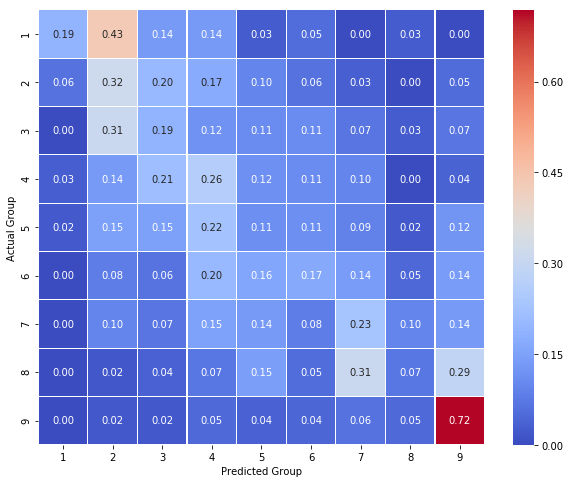

In [174]:
# Create confusion matrix
CROSSTAB = pd.crosstab(Rf_result['testAnswer'], Rf_result['Predict'], rownames=['Actual Group'], colnames=['Predicted Group'])
for i in range(9):
    CROSSTAB.loc[i+1]/=sum(CROSSTAB.loc[i+1])
plt.figure(figsize = (10,8))
g = sns.heatmap(CROSSTAB,annot=True, fmt = ".2f", cmap = "coolwarm",linewidths= 0.01)

## Feature importance for random forest

In [176]:
dec_fea = pd.DataFrame(Rfclf.feature_importances_,columns=['importance'])
dec_fea["name"] = list(X_train) 
dec_fea.sort_values(by='importance', ascending=False).head()

,importance,name
0,0.328276,budget
14,0.032860,Comedy
15,0.030827,Romance
10,0.028875,Thriller
9,0.026539,Drama


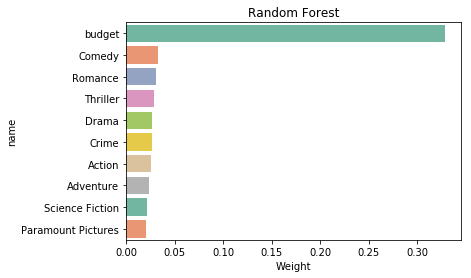

In [178]:
g = sns.barplot('importance',"name",data = dec_fea.sort_values(by='importance', ascending=False)[0:10], palette="Set2",orient = "h")
g.set_xlabel("Weight")
g = g.set_title("Random Forest")

In [179]:
X_train.columns

Index(['budget', 'ShortMovie', 'NotTooLongMovie', 'LongMovie', 'Action',
       'Adventure', 'Fantasy', 'Science Fiction', 'Crime', 'Drama', 'Thriller',
       'Animation', 'Family', 'Western', 'Comedy', 'Romance', 'Horror',
       'Mystery', 'History', 'War', 'Music', 'Documentary', 'Foreign', '',
       'duringcreditsstinger', 'based on novel', 'woman director',
       'aftercreditsstinger', 'murder', 'dystopia', 'independent film',
       'violence', '3d', 'revenge', 'Steven Spielberg', 'Clint Eastwood',
       'Ridley Scott', 'Martin Scorsese', 'Robert Rodriguez', 'Renny Harlin',
       'Tim Burton', 'Steven Soderbergh', 'Robert Zemeckis', 'Oliver Stone',
       'Bruce Willis', 'Johnny Depp', 'Nicolas Cage', 'Denzel Washington',
       'Robert De Niro', 'Tom Hanks', 'Tom Cruise', 'Arnold Schwarzenegger',
       'Matt Damon', 'Ben Stiller', 'Paramount Pictures', 'Universal Pictures',
       'Columbia Pictures', 'Twentieth Century Fox Film Corporation',
       'New Line Cinema', 'Wal

In [200]:
Solo = np.array([200e+6,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                 0,0,0,0,0,0,1,0,1,0,
                 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                 0,0,0,0,0,1,0,0,0,0,0
            ])

In [198]:
DeadPool2 = np.array([0e+6,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,1,0,1,1,0,
             0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
             0,0,0,1,0,0,0,0,0,0,0
            ])

In [199]:
Rfclf.predict(DeadPool2.reshape(1,65))

array([9])

In [201]:
Rfclf.predict(Solo.reshape(1,65))

array([9])